In [ ]:
import os
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")

import re
import matplotlib.pyplot as plt
import seaborn as sns
plot_settings = {'ytick.labelsize': 16,
                        'xtick.labelsize': 16,
                        'font.size': 22,
                        'figure.figsize': (10, 5),
                        'axes.titlesize': 22,
                        'axes.labelsize': 18,
                        'lines.linewidth': 2,
                        'lines.markersize': 3,
                        'legend.fontsize': 11,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'}
plt.style.use(plot_settings)
# Set the seaborn style and font scale for publication
# Set the seaborn style and font scale for publication
# sns.set(style="whitegrid", font_scale=1.2, )
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16})


def parse_metric_text_short(text):
    pattern = r'acc(\d+\.\d+)_roc(\d+\.\d+)_prc(\d+\.\d+)_f1(\d+\.\d+)\.pt'
    match = re.match(pattern, text)

    if match:
        metric_dict = {
            'accuracy': float(match.group(1)),
            'auroc': float(match.group(2)),
            'auprc': float(match.group(3)),
            'f1_score': float(match.group(4))
        }
        return metric_dict
    else:
        raise ValueError("Invalid text format")


def parse_metric_text(text):
    pattern = r'acc(\d+\.\d+)_roc(\d+\.\d+)_prc(\d+\.\d+)_f1(\d+\.\d+)_mcc(\d+\.\d+)_precision(\d+\.\d+)_recall(\d+\.\d+)\.pt'
    match = re.match(pattern, text)

    if match:
        metric_dict = {
            'Accuracy': float(match.group(1)),
            'AUROC': float(match.group(2)),
            'AUPRC': float(match.group(3)),
            'F1': float(match.group(4)),
            'MCC': float(match.group(5)),
            'Precision': float(match.group(6)),
            'Recall': float(match.group(7))
        }
        return metric_dict
    else:
        raise ValueError("Invalid text format")


def summarize_result(result_dir):
    df = pd.DataFrame()
    for len_dir in os.listdir(result_dir):
        len_path = os.path.join(result_dir, len_dir)
        for file in os.listdir(len_path):
            try:
                line = file[2:]
                metric_dict = parse_metric_text(line)
                # add a row of length, and metric to df
                metric_dict['length'] = len_dir
                df = df.append(metric_dict, ignore_index=True)
            except:
                pass
    return df
            

In [14]:
esm_df = summarize_result("result")
esm_df = esm_df[esm_df['F1'] > 0]
esm_df=esm_df.groupby('length').mean().reset_index()
esm_df.mean()

length       1.013830e+20
Accuracy     8.694223e-01
AUROC        7.537446e-01
AUPRC        4.070245e-01
F1           2.270247e-01
MCC          2.431467e-01
Precision    6.161189e-01
Recall       1.491622e-01
dtype: float64

In [16]:
# combine the mean of two dataframes into one and add a column to indicate the model 
esm_df['model'] = 'ESM-2-650M'
mamba_df['model'] = 'PTM-Mamba'
df = pd.concat([esm_df, mamba_df])
avg_df = df.groupby(['model']).mean().reset_index().round(3)
avg_df.index = ['ESM-2-650M', 'PTM-Mamba']
"""
On PTM-related task like PTM site prediction, PTM-Mamba outperforms ESM-650M in all metrics except for AUROC.
Notably, the input to PTM-Mamba is regular AAs which isn't the data type that PTM-Mamba was trained on, PTM-Mamba still shows understanding of PTM context in the sequence.
In different sequence length, PTM-Mamba consistently shows better performance than ESM-650M in terms of Accuracy, AUPRC, Precision.
"""


"\nOn PTM-related task like PTM site prediction, PTM-Mamba outperforms ESM-650M in all metrics except for AUROC.\nNotably, the input to PTM-Mamba is regular AAs which isn't the data type that PTM-Mamba was trained on, PTM-Mamba still shows understanding of PTM context in the sequence.\nIn different sequence length, PTM-Mamba consistently shows better performance than ESM-650M in terms of Accuracy, AUPRC, Precision.\n"

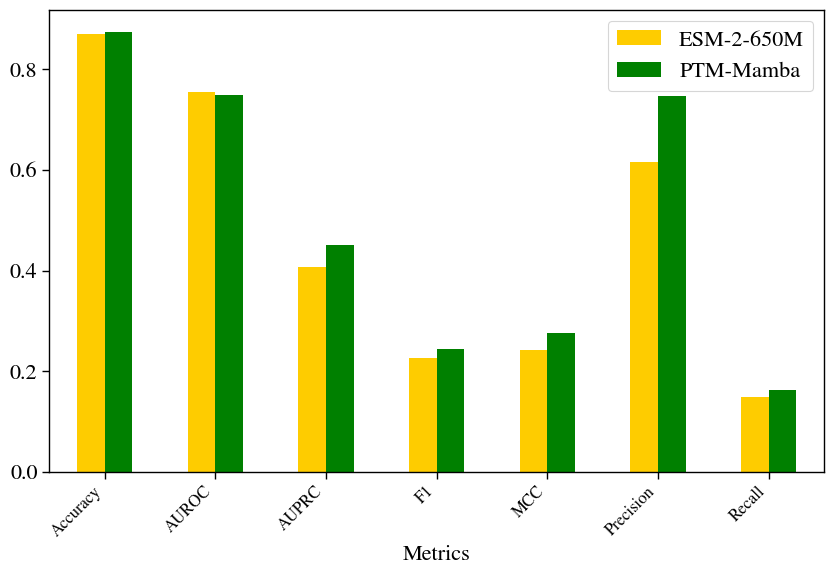

In [26]:


avg_df['model']=avg_df.index
# Set the model column as the index for better plotting
avg_df.set_index('model', inplace=True)

# Plotting
 #fecc00 for ESM-2, #008000 for PTM-Mamba

ax = avg_df.T.plot(kind='bar', figsize=(10, 6), color=['#fecc00', '#008000'])
ax.set_xlabel('Metrics',)
plt.legend( fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

plt.show()


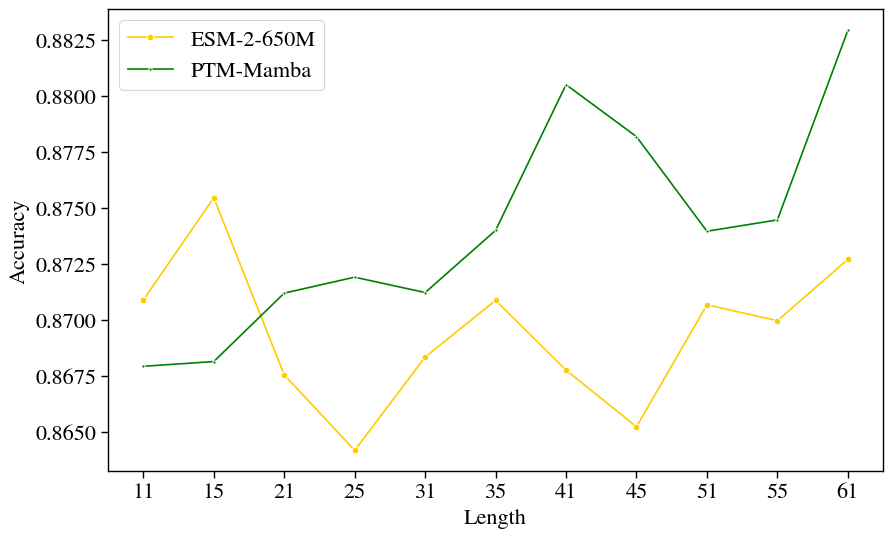

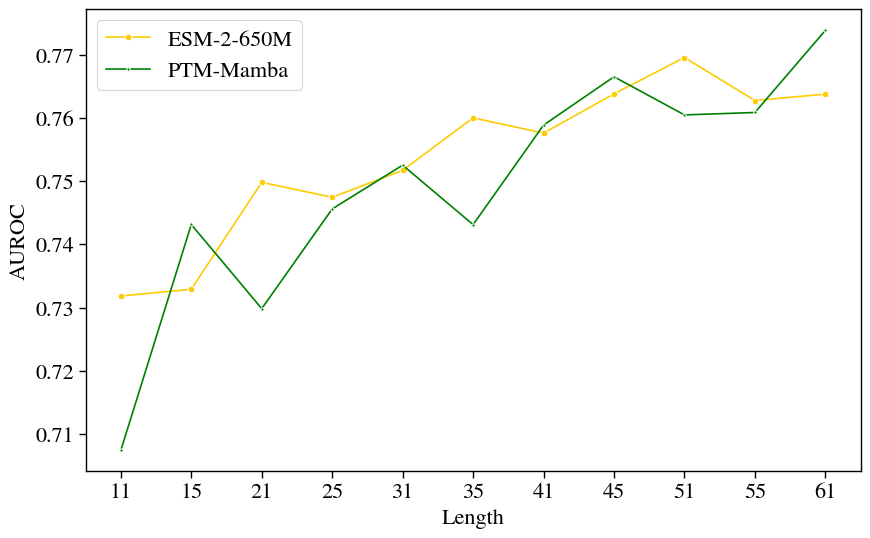

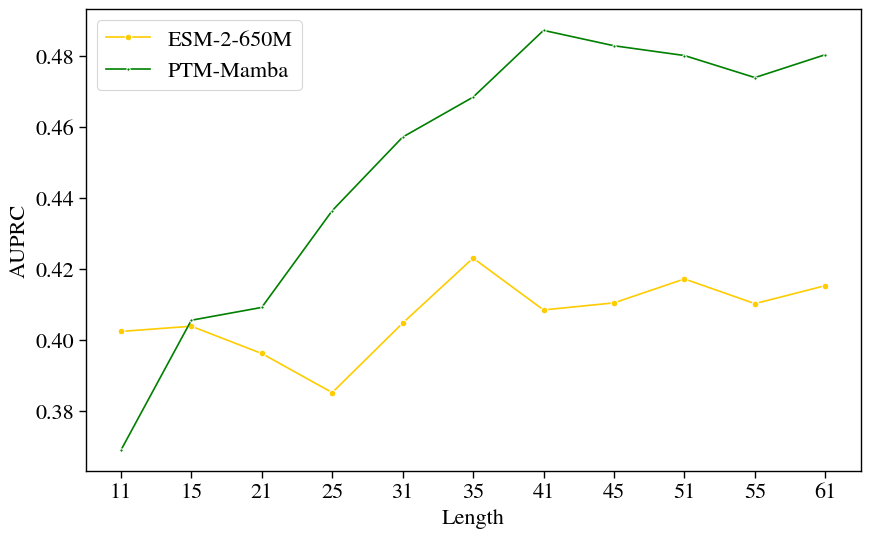

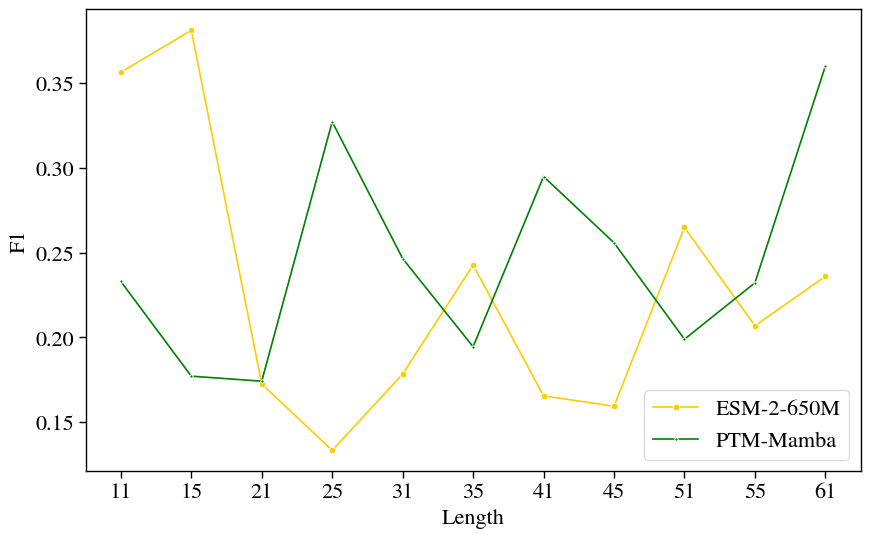

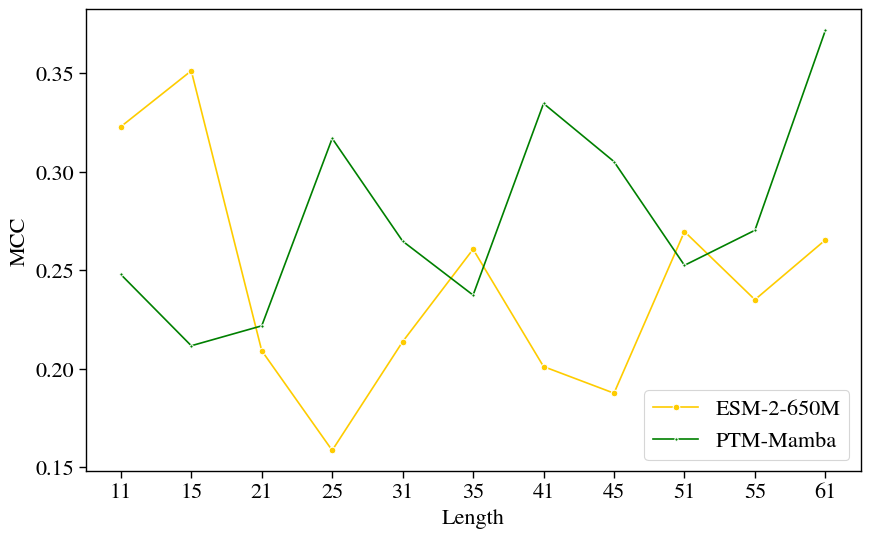

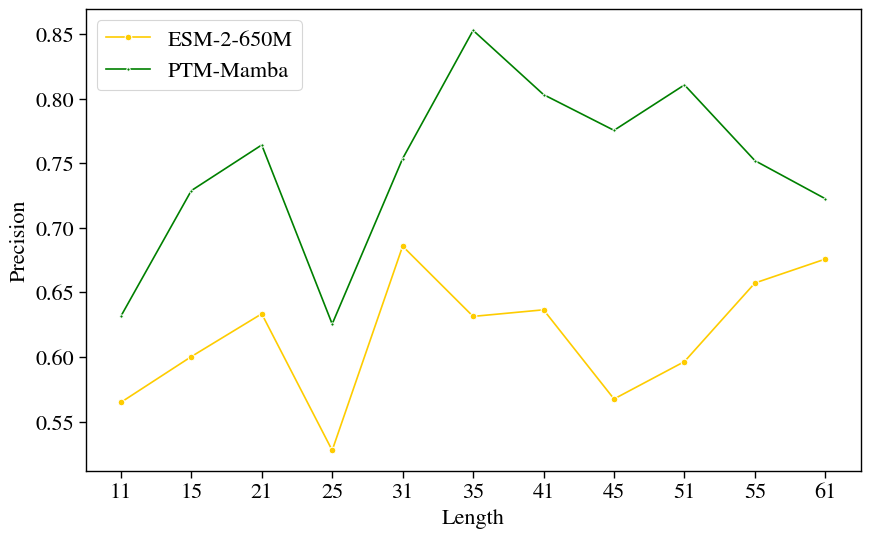

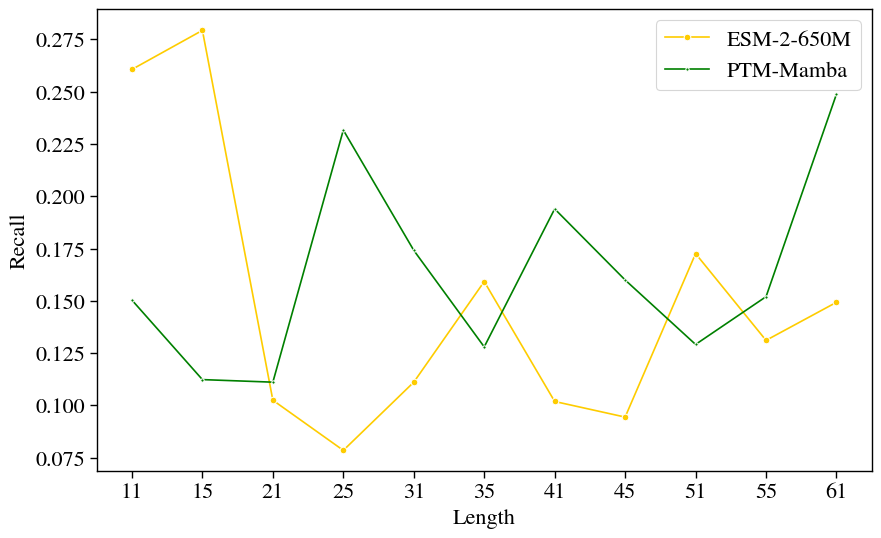

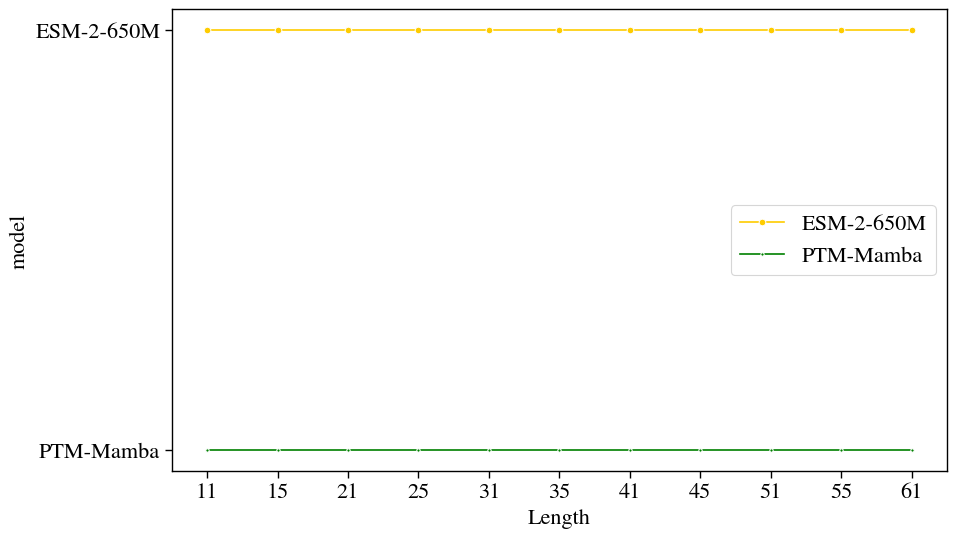

In [28]:
# Plotting for each metric using seaborn
os.makedirs('figures', exist_ok=True)
metrics = esm_df.columns[1:]
for metric in metrics:
    plt.figure(figsize=(10, 6))
    #fecc00 for ESM-2, #008000 for PTM-Mamba
    sns.lineplot(x='length', y=metric, data=esm_df, label='ESM-2-650M', marker='o', color='#fecc00')
    sns.lineplot(x='length', y=metric, data=mamba_df, label='PTM-Mamba', marker='.', color='#008000')
    
    plt.xlabel('Length', fontsize=16)
    plt.ylabel(metric, fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    # plt.title(f'{metric.capitalize()} Comparison', fontsize=16)
    plt.legend(fontsize=16)
    # plt.tight_layout( )
    plt.savefig(f'figures/{metric}.png')
    plt.show()
    
    

In [19]:
seq = pd.read_csv("/workspace/protein_lm/dataset/ptm_labels.csv")
seq

,Unnamed: 0,AC_ID,pos,label,ori_seq,token
0,7,Q8VBW9,4,N-linked (GlcNAc...) asparagine,MPGQNYSTISEFILFGFSAFPHQMLPALFLLYLLMYLFTLLGNLVI...,<N-linked (GlcNAc...) asparagine>
1,8,Q60885,4,N-linked (GlcNAc...) asparagine,MGDDNDTDITEFILLGFSGYGFLQGHLFWGVLCIYVVTLLGNSLIV...,<N-linked (GlcNAc...) asparagine>
2,75,P13744,21,Pyrrolidone carboxylic acid,MARSSLFTFLCLAVFINGCLSQIEQQSPWEFQGSEVWQQHRYQSPR...,<Pyrrolidone carboxylic acid>
3,89,P48347,64,Phosphoserine,MENEREKQVYLAKLSEQTERYDEMVEAMKKVAQLDVELTVEERNLV...,<Phosphoserine>
4,90,P48347,187,Phosphoserine,MENEREKQVYLAKLSEQTERYDEMVEAMKKVAQLDVELTVEERNLV...,<Phosphoserine>
...,...,...,...,...,...,...
311345,791254,Q6KAQ7,137,Phosphoserine,MVGTCHSMAASRSTRVTRSTVGLNGLDESFCGRTLRNRSIAHPEEI...,<Phosphoserine>
311346,791255,Q6KAQ7,141,Phosphoserine,MVGTCHSMAASRSTRVTRSTVGLNGLDESFCGRTLRNRSIAHPEEI...,<Phosphoserine>
311347,791256,Q6KAQ7,400,N6-acetyllysine,MVGTCHSMAASRSTRVTRSTVGLNGLDESFCGRTLRNRSIAHPEEI...,<N6-acetyllysine>
311348,791257,Q6KAQ7,612,Phosphoserine,MVGTCHSMAASRSTRVTRSTVGLNGLDESFCGRTLRNRSIAHPEEI...,<Phosphoserine>


In [20]:
seq['length'] = seq['ori_seq'].apply(len)

Text(0, 0.5, 'Count')

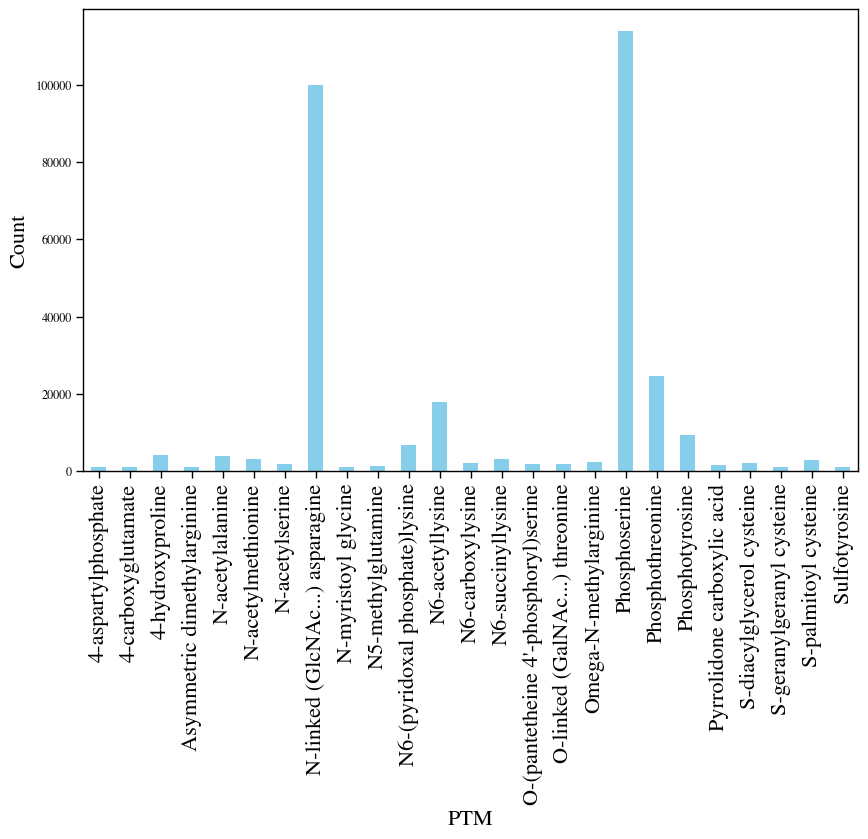

In [24]:
# rotate the x-axis labels
seq['label'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.xticks(fontsize=16)
plt.xlabel('PTM')
plt.ylabel('Count')

([<matplotlib.axis.XTick at 0x7f745fd3a260>,
 [Text(0, 0, '3'),
  Text(500, 0, '504'),
  Text(1000, 0, '1004'),
  Text(1500, 0, '1505'),
  Text(2000, 0, '2075'),
  Text(2500, 0, '2887')])

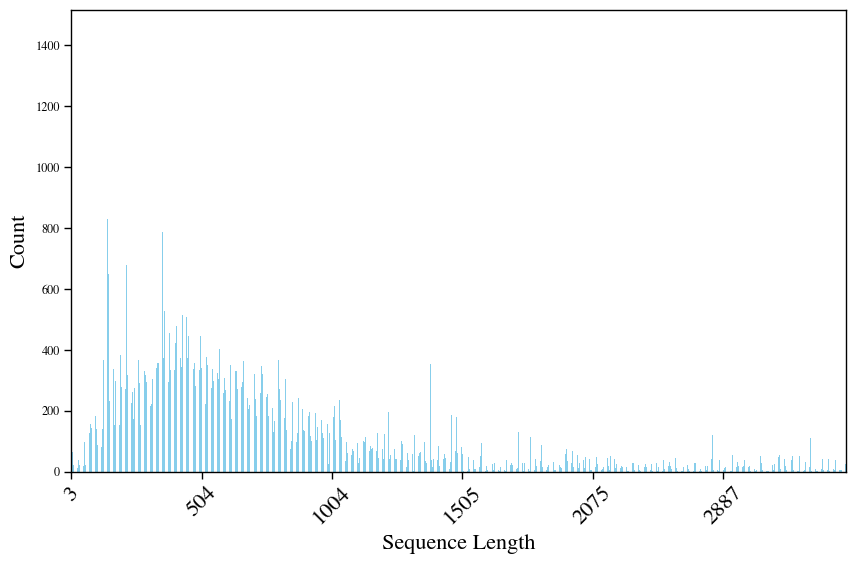

In [25]:
# the x axis has too many labels please only show a few of them
seq['length'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
# Set x-axis ticks to show only a subset of labels
plt.xticks(range(0, len(seq['length'].value_counts()), 500), rotation=45,fontsize=16)
# The range above specifies that every 5th tick will be displayed. You can adjust this based on your preference.


In [23]:
pd.read_csv("/workspace/protein_lm/evaluation/binding_site_prediction/data/ptm_data.csv").shape

(79707, 9)